In [2]:
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [3]:
examples = glob.glob('examples/*.png')
examples

['examples\\0162681551.png',
 'examples\\0168366051.png',
 'examples\\0168639352.png']

In [4]:
examples = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in examples]

In [5]:
examples[0].shape

(256, 256)

In [6]:
import PIL.Image
import IPython.display

def show(arr):
    IPython.display.display(PIL.Image.fromarray(arr))

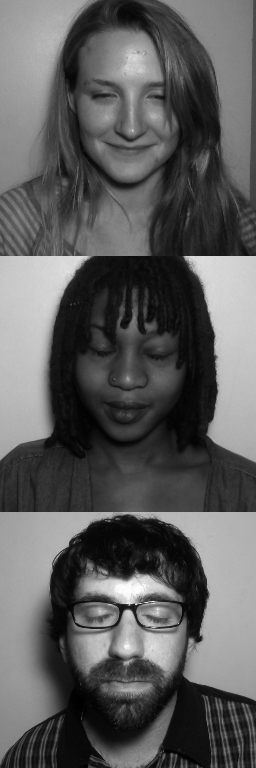

In [7]:
show(np.concatenate(examples, axis=0))

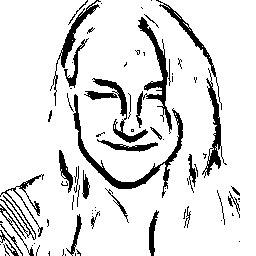

In [8]:
from functools import wraps
import time
profiles = {}
%load_ext line_profiler

def profile(f):
    name = f.__name__
    profiles[name] = 0.0
    @wraps(f)
    def wrapped(*args, **kwargs):
        start = time.time()
        res = f(*args, **kwargs)
        profiles[name] += (time.time() - start)
        return res
    return wrapped

def cld(*args):
    return cv2.imread('examples/cld/cld_0162681551.png', cv2.IMREAD_GRAYSCALE)
    
edges = raster_edges(examples[0])

edges[:, 240:] = 255
show(edges)

In [9]:
profiles

{'raster_edges': 0.002993345260620117}

In [10]:
!.\potrace-1.16.win64\potrace.exe -h

potrace 1.16. Transforms bitmaps into vector graphics.

Usage: potrace [options] [filename...]
General options:
 -h, --help                 - print this help message and exit
 -v, --version              - print version info and exit
 -l, --license              - print license info and exit
File selection:
 <filename>                 - an input file
 -o, --output <filename>    - write all output to this file
 --                         - end of options; 0 or more input filenames follow
Backend selection:
 -b, --backend <name>       - select backend by name
 -b svg, -s, --svg          - SVG backend (scalable vector graphics)
 -b pdf                     - PDF backend (portable document format)
 -b pdfpage                 - fixed page-size PDF backend
 -b eps, -e, --eps          - EPS backend (encapsulated PostScript) (default)
 -b ps, -p, --postscript    - PostScript backend
 -b pgm, -g, --pgm          - PGM backend (portable greymap)
 -b dxf                     - DXF backend (drawing int

In [11]:
cv2.imwrite("output.bmp", edges)
!.\potrace-1.16.win64\potrace.exe output.bmp -o output.geojson -b geojson
!.\potrace-1.16.win64\potrace.exe output.bmp -o output.svg -b svg

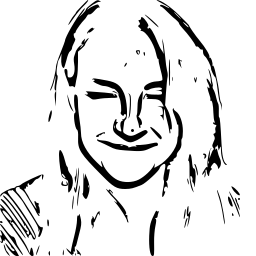

In [12]:
IPython.display.SVG('output.svg')

In [13]:
import json
with open('output.geojson') as fp:
    geojson = json.load(fp)

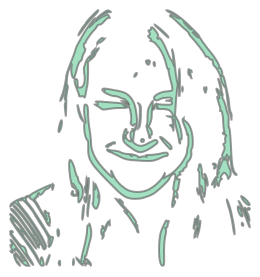

In [14]:
from shapely import geometry as geom

shapes = [geom.shape(feature["geometry"]) for feature in geojson['features']]
geom.GeometryCollection(shapes)

centerlining: 100%|████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 17.76it/s]


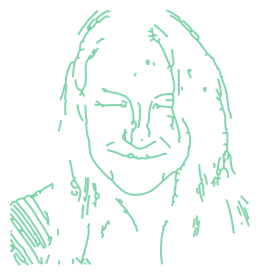

In [39]:
from centerline.geometry import Centerline 
from shapely import ops

def extract_centerlines(shapes):
    centerlines = [Centerline(poly, valid=True) 
                   for poly in tqdm.tqdm(shapes, desc='centerlining')
                   if type(shapes[0]) == geom.Polygon]
    center_geoms = [line.geoms for line in centerlines]
    center_geom_lines = [geom.MultiLineString(line) for line in center_geoms]
    center_geom_lines = [ops.linemerge(line) for line in center_geom_lines]
    return center_geom_lines

# profile: 
# %lprun -u 0.001 -f extract_centerlines geom.GeometryCollection(extract_centerlines(shapes))
center_geom_lines = extract_centerlines(shapes)
geom.GeometryCollection(center_geom_lines)

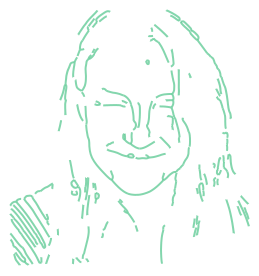

In [40]:
def explode_multilines(lines):
    out = []
    for line in lines:
        if type(line) == geom.multilinestring.MultiLineString:
            out.extend([subline for subline in line])
        else:
            out.append(line)
    return out

center_geom_lines = explode_multilines(center_geom_lines)

center_geom_lines = [line for line in center_geom_lines 
                     if max(line.length, geom.Point(line.coords[0]).distance(geom.Point(line.coords[-1]))) > 4]

geom.GeometryCollection(center_geom_lines)

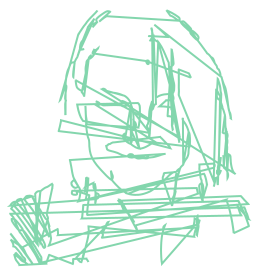

In [41]:
def merge_naive(lines):
    all_coords = [list(line.coords) for line in lines]
    flattened = [coord for coords in all_coords for coord in coords]
    return geom.LineString(flattened)

merge_naive(center_geom_lines)

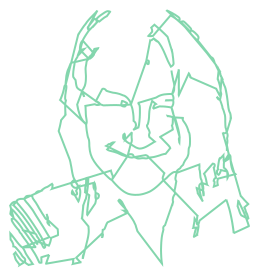

In [42]:
from math import sqrt

def greedy_reorder(lines):
    ''' Reorder list of LineStrings greedily by lowest tail-tip distance'''
    lines = lines[:]
    curr = lines.pop()
    out = []
    while len(lines) > 0:
        start_curr = geom.Point(curr.coords[0])
        end_curr = geom.Point(curr.coords[-1])
        dist = float('+inf')
        nearest_tail = None
        for other in lines:
            start_o = geom.Point(other.coords[0])
            end_o = geom.Point(other.coords[-1])
            if end_curr.distance(start_o) < dist:
                dist = end_curr.distance(start_o)
                nearest_tail = other
            elif end_curr.distance(end_o) < dist:
                dist = end_curr.distance(end_o)
                other.coords = list(other.coords)[::-1]
                nearest_tail = other
        lines.remove(nearest_tail)
        out.append(nearest_tail)
        curr = nearest_tail
    return out

ordered_lines = greedy_reorder(center_geom_lines)
merge_naive(ordered_lines)

We can try ordering the lines by their distance to the center as the first paths in the list have more next-lines to chose from, and so hopefully the center of the face will get the best "picks".
We can also try ordering by start point closest to center or end point closest to center

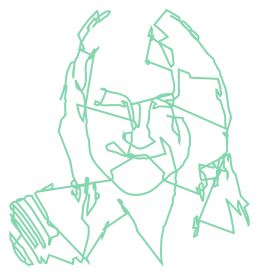

In [43]:
def reorder_center_dist(lines):
    bounds = geom.MultiLineString(lines).bounds
    center = geom.Point((bounds[2] - bounds[0])/2, (bounds[3] - bounds[1])/2)
    def dist(line):
        return center.distance(line.centroid)
    return sorted(lines, key=dist)

ordered_by_closest_to_center = reorder_center_dist(center_geom_lines)
ordered_lines = greedy_reorder(ordered_by_closest_to_center)
merge_naive(ordered_lines)

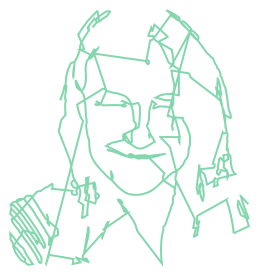

In [44]:
def reorder_start_dist(lines):
    bounds = geom.MultiLineString(lines).bounds
    center = geom.Point((bounds[2] - bounds[0])/2, (bounds[3] - bounds[1])/2)
    def dist(line):
        return center.distance(geom.Point(line.coords[0]))
    return sorted(lines, key=dist)

ordered_by_closest_to_center = reorder_start_dist(center_geom_lines)
ordered_lines = greedy_reorder(ordered_by_closest_to_center)
merge_naive(ordered_lines)

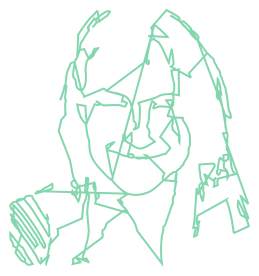

In [45]:
def reorder_end_dist(lines):
    bounds = geom.MultiLineString(lines).bounds
    center = geom.Point((bounds[2] - bounds[0])/2, (bounds[3] - bounds[1])/2)
    def dist(line):
        return center.distance(geom.Point(line.coords[-1]))
    return sorted(lines, key=dist)

ordered_by_closest_to_center = reorder_end_dist(center_geom_lines)
ordered_lines = greedy_reorder(ordered_by_closest_to_center)
merge_naive(ordered_lines)

In [46]:


def sobel(gray):
    scale = 1
    delta = 0
    ddepth = cv2.CV_32FC1

    grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    # Gradient-Y
    # grad_y = cv.Scharr(gray,ddepth,0,1)
    grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    
    
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    
    
    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    return grad

grad = sobel(test)
show(grad)

NameError: name 'test' is not defined

In [ ]:
grad_blurred = cv2.GaussianBlur(grad / grad.max(), (9, 9), 5.0)

In [ ]:
show((grad_blurred * 255).astype(np.uint8))

In [ ]:
import numpy as np

gp = grad_blurred.copy()
gp[gp < (gp.mean() + 0.5 * gp.std())] = 0.0
prob = gp
sample_at = (np.random.poisson(prob + 0.001, (256, 256)) > 0).astype(np.uint8)
show(255 * sample_at)

In [ ]:
sampled_grad_pixels = grad * sample_at
sampled_grad_pixels[0, 0] = 1
sampled_grad_pixels[-1, -1] = 1
sampled_grad_pixels[0, -1] = 1
sampled_grad_pixels[-1, 0] = 1
show(sampled_grad_pixels)

In [ ]:
sampled_grad_pixels.max()

In [ ]:
import scipy.spatial

nonzero_ys, nonzero_xs = np.nonzero(sampled_grad_pixels)
grad_values = sampled_grad_pixels[nonzero_ys, nonzero_xs]
nonzero_coords = np.dstack((255 - nonzero_ys, nonzero_xs)).squeeze().astype(np.float32)
tri = scipy.spatial.Delaunay(nonzero_coords)

pixel_vals = sampled_grad_pixels[255 - nonzero_ys, nonzero_xs]

plt.figure(figsize=(10, 10))
plt.tripcolor(nonzero_xs, 255 - nonzero_ys, tri.simplices, np.ones_like(pixel_vals), edgecolor="red")

In [ ]:
start_node_id = tri.find_simplex(nonzero_coords[0])
start_node_id, tri.simplices[start_node_id]

def to_graph(tri):
    nbrs = {i:set() for i in range(len(tri.points))}

    for smplx in tri.simplices:
        nbrs[smplx[0]].add(smplx[1])
        nbrs[smplx[1]].add(smplx[2])
        nbrs[smplx[2]].add(smplx[0])

        nbrs[smplx[1]].add(smplx[0])
        nbrs[smplx[2]].add(smplx[1])
        nbrs[smplx[0]].add(smplx[2])
    
    return nbrs

graph = to_graph(tri)

In [ ]:
graph[896]

In [ ]:
import heapq
from collections import defaultdict

def extract_path_rec(from_key, to_key, reverse_paths, out_list):
    next_key = reverse_paths[from_key]
    
    if next_key != to_key and next_key in reverse_paths:
        extract_path_rec(next_key, to_key, reverse_paths, out_list)
        
    out_list.append(next_key)
    return out_list

def extract_path(from_key, to_key, reverse_paths):
    path = extract_path_rec(from_key, to_key, reverse_paths, [])
    path.append(from_key)
    return path

def a_star(start_vertex, goal_vertex, graph, distance, heuristic):
    if start_vertex == goal_vertex:
        return [start_vertex, goal_vertex]
    q = [(0, start_vertex)]
    possible_nexts = set([start_vertex])
    reverse_paths = {}
    cheapest_paths = defaultdict(lambda: float('+inf'))
    cheapest_total = defaultdict(lambda: float('+inf'))
    cheapest_paths[start_vertex] = 0
    while len(possible_nexts) > 0:
        curr_f, curr = heapq.heappop(q)
        possible_nexts.remove(curr)
        if curr == goal_vertex:
            return extract_path(goal_vertex, start_vertex, reverse_paths)
        
        if curr not in graph:
            continue
        nbrs = graph[curr]
        
        for nbr in nbrs:
            h = distance(curr, nbr)
            maybe_best_g = h + cheapest_paths[curr]
            if cheapest_paths[nbr] > maybe_best_g:
                reverse_paths[nbr] = curr
                cheapest_paths[nbr] = maybe_best_g
                f = maybe_best_g + heuristic(nbr, goal_vertex)
                if nbr not in possible_nexts:
                    possible_nexts.add(nbr)
                    heapq.heappush(q, (f, nbr))

In [ ]:
import time

def merge_naive(lines):
    all_coords = [list(line.coords) for line in lines]
    flattened = [coord for coords in all_coords for coord in coords]
    return geom.LineString(flattened)

def pt_vert_distance(pt, tri, idx):
    coords = geom.Point(tri.points[idx])
    return coords.distance(pt)

def insert_a_star_connections(lines, tri, graph_copy):
    remaining_lines = set(range(len(lines)))
    curr_idx = 0
    out = [lines[curr_idx]]
    remaining_lines.remove(curr_idx)
    pts_added = []
    knn_time = 0.0
    astar_time = 0.0
    while len(remaining_lines) > 0:
        
        curr = lines[curr_idx]
        end_curr = geom.Point(curr.coords[-1])
        dist = float('+inf')
        
        nearest_tail = None
        nearest_tail_idx = None
        flip = False
        
        knn_start = time.time()
        
        for other_idx in remaining_lines:
            other = lines[other_idx]
            start_o = geom.Point(other.coords[0])
            end_o = geom.Point(other.coords[-1])
           
            if end_curr.distance(start_o) < dist:
                flip = False
                dist = end_curr.distance(start_o)
                nearest_tail = other
                nearest_tail_idx = other_idx
            elif end_curr.distance(end_o) < dist:
                flip = True
                dist = end_curr.distance(end_o)
                nearest_tail = other
                nearest_tail_idx = other_idx
        
        knn_time += (time.time() - knn_start)
        
        if flip:
            nearest_tail.coords = list(nearest_tail.coords)[::-1]
        
        remaining_lines.remove(nearest_tail_idx)
        
        next_start_x, next_start_y = nearest_tail.coords[0]
        goal_pos = geom.Point(next_start_x, next_start_y)
        
        goal_smplx_idx = tri.find_simplex(goal_pos)
        goal_smplx = tri.simplices[goal_smplx_idx]
        nearest_smplx_corner_to_goal = min(goal_smplx, key=lambda idx: pt_vert_distance(goal_pos, tri, idx))
        
        curr_smplx_idx = tri.find_simplex(end_curr)
        curr_smplx = tri.simplices[curr_smplx_idx]
        nearest_smplx_corner_to_curr = min(curr_smplx, key=lambda idx: pt_vert_distance(end_curr, tri, idx))
        
        if (nearest_smplx_corner_to_goal != nearest_smplx_corner_to_curr
            and nearest_smplx_corner_to_goal in graph_copy
            and nearest_smplx_corner_to_curr in graph_copy):
            astar_start = time.time()
            path_between = a_star(nearest_smplx_corner_to_curr, nearest_smplx_corner_to_goal, graph_copy, weight, heuristic)
            astar_time += (time.time() - astar_start)
            if path_between is not None:
                for i in range(len(path_between) - 1):
                    p_i = path_between[i]
                    p_next = path_between[i + 1]
                    graph_copy[p_i].remove(p_next)
                    #del graph_copy[p_i]
                    #print('del', p_i)

                pts_between = [tuple(tri.points[idx]) for idx in path_between]
                pts_added.append(geom.LineString(pts_between))
                out.append(geom.LineString(pts_between))

        out.append(nearest_tail)
        curr_idx = nearest_tail_idx
    print(f"knn_time: {knn_time:.3f}s\nastar_time: {astar_time:.3f}s")
    return out, pts_added


def distance(i, j):
    i_pos = tri.points[i]
    j_pos = tri.points[j]
    dx = i_pos - j_pos
    return np.linalg.norm(dx)

def heuristic(i, goal):
    dist = distance(i, goal)
    coords = tri.points[i].astype(np.int)
    edginess = grad_blurred[coords[0], coords[1]]/grad_max
    return (1.0 - edginess)*10

grad_max = grad_blurred.max()
inv_grad = 1.0 - grad_blurred

def weight(i, j):
    dist = distance(i, j) ** 1.1
    i_pos = tri.points[i]
    j_pos = tri.points[j]
    
    mid = (i_pos + j_pos).astype(np.int) // 2
    edginess = grad_blurred[mid[0], mid[1]]/grad_max
    return dist
    
a_star(0, len(graph)-1, graph, weight, heuristic)
graph = to_graph(tri)

a_star_connected, added_pts = insert_a_star_connections(reorder_start_dist(center_geom_lines), tri, graph)
merged = merge_naive(a_star_connected) 
merged

In [ ]:
geom.GeometryCollection(added_pts)

In [ ]:
merge_naive(greedy_reorder(reorder_center_dist(center_geom_lines)))

1. make few canny edges
2. solve for path
3. pick connectors from dense edges

aka

1. make lots of canny edges
2. solve for path by picking points in between ends and snapping them to nearest lines

or

1. make edges
2. a* w/ heuristics based on edgi-ness of pixel along delauncy triangulion of face or polar grid

+

1. centerline optimization